<a href="https://colab.research.google.com/github/kavyajeetbora/metro_accessibility/blob/master/notebooks/ETL_Station_Footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q pydeck

In [94]:
!touch __init__.py

In [95]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import pydeck as pdk
import shapely
import duckdb
import time
import warnings
import requests
from lxml import etree

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Setup duckdb

In [96]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [97]:
%%sql
INSTALL httpfs;
INSTALL spatial;

,Success


## Download OSM data

Download all the station nodes:

In [98]:
!wget -q https://github.com/kavyajeetbora/metro_accessibility/raw/master/data/delhi/Delhi_NCR_station_nodes.gpkg -O station_nodes.gpkg
station_nodes = gpd.read_file('station_nodes.gpkg', crs='EPSG:4326')
print(station_nodes.shape)
station_nodes.sample(4)

(262, 6)


,name,railway,network,operator,source,geometry
120,Laxmi Nagar,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.27746 28.63047)
47,Model Town,None,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.19391 28.70290)
236,Shiv Vihar,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.28940 28.72160)
114,Noida Sector 15,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.31175 28.58493)


In [ ]:
pb_gdf['station'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
station,
None,1054
subway,271
miniature,1


In [ ]:
pb_gdf['subway'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
subway,
yes,1222
None,104


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

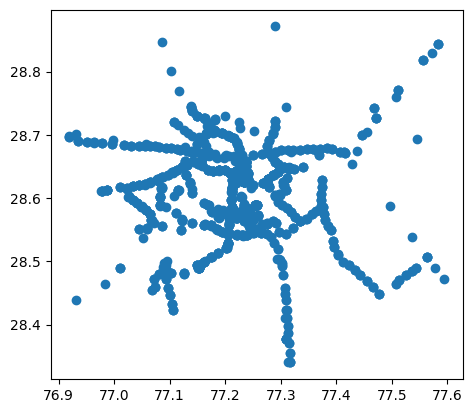

In [ ]:
pb_gdf.plot()

### Filter the public transport nodes

in this study, we want only the subway lines including the monorail

In [ ]:
condition = ((pb_gdf['subway']=='yes') | (pb_gdf['station']=='monorail')) & (pb_gdf['railway']!='construction')
metro_stations = pb_gdf.loc[condition]
metro_stations = metro_stations.drop(['osmid','element_type'], axis=1)
print("Total stations found", metro_stations.shape[0])
metro_stations.sample(3)

Total stations found 1222


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
826,POINT (77.17036 28.71700),subway_entrance,None,Adarsh Nagar Metro Gate No 1,Delhi Metro,Delhi Metro Rail Corporation Limited,None,1,None,yes,None
228,POINT (77.02598 28.60222),station,None,Dwarka Sector 14,Delhi Metro,Delhi Metro Rail Corporation Limited,station,DSFN,None,yes,subway
492,POINT (77.02237 28.61591),stop,None,Dwarka (Grey Line),Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,DW,None,yes,None


In [ ]:
metro_stations.to_file(f'{city}_stations_stops.gpkg', driver='GPKG')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Buffered Stations

Station nodes in OSM maynot be labelled with correct tags, so this may required evaluation before processing.

Converting the project to mercator projection for creating a 10m buffer area around the station



In [ ]:
buffered_stations = metro_stations.copy()
buffered_stations = buffered_stations.to_crs('EPSG:3857')
buffered_stations['geometry'] = buffered_stations['geometry'].buffer(10)
buffered_stations = buffered_stations.to_crs("EPSG:4326")
buffered_stations.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
0,"POLYGON ((77.04084 28.59225, 77.04084 28.59224...",stop,None,Dwarka Sector 12,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,DSW,None,yes,None
1,"POLYGON ((77.03365 28.59702, 77.03364 28.59702...",stop,None,Dwarka Sector 13,Delhi Metro,Delhi Metro Rail Corporation Limited,stop_position,DSTN,None,yes,None


In [ ]:
buffered_stations.to_parquet('stations-buffered.parquet')
buffered_stations.geometry.geom_type.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Polygon'], dtype=object)

## Download Station Buildings

Downloading the buildings from overturemaps using duckdb

The overture map's data keeps on updating month on month. Refer to the release notes to download the latest data: [lastest releases](https://docs.overturemaps.org/release/latest/)

Since the overture maps data keeps on getting updated on monthly basis, it is important to stick to the latest available data. You can get the latest release information from their website: [Latest Release Overture Maps Data](https://docs.overturemaps.org/release/latest/) or you can directly scrape the information from their website. Here is a small code to get the latest release info:



In [ ]:
try:
    url = r'https://docs.overturemaps.org/release/latest/'
    req = requests.get(url)
    html_text = req.text
    tree = etree.HTML(html_text)

    result = tree.xpath('//h1')
    latest_release = result[0].text
    print("latest Overture map release:" ,latest_release)

except Exception as e:
    print("Error", e)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


latest Overture map release: 2024-08-20.0


Update the `buildings_data_url` to the latest map release and run the code below:

In [ ]:
%%time

buildings_data_url = rf"'s3://overturemaps-us-west-2/release/2024-08-20.0/theme=buildings/type=*/*'"
stations_data_url = "'stations-buffered.parquet'"

df = duckdb.sql(
    f'''
    LOAD spatial;
    LOAD httpfs;
    COPY(
        SELECT
            id,
            names.primary as name,
            buildings.height as height,
            stations.name as station_name,
            stations.network as network,
            stations.operator as operator,
            stations.railway as railway,
            stations.subway as subway,
            stations.station as station,
            ST_GeomFromWKB(buildings.geometry) as geom
        FROM read_parquet({buildings_data_url}, filename=true, hive_partitioning=1) AS buildings
        JOIN read_parquet({stations_data_url}) as stations
        ON ST_Intersects(ST_GeomFromWKB(buildings.geometry), ST_GeomFromWKB(stations.geometry))
        WHERE buildings.bbox.xmin > {W}
        AND buildings.bbox.xmax < {E}
        AND buildings.bbox.ymin > {S}
        AND buildings.bbox.ymax < {N}
    ) TO '{city}_station_buildings_v1.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
   '''
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 56.1 s, sys: 4.37 s, total: 1min
Wall time: 2min 4s


In [ ]:
sbf = gpd.read_file(f'{city}_station_buildings_v1.geojson').drop_duplicates('geometry')  ## Unique Building footprints
print('Stations with enclosing buildings:', sbf.shape[0])
sbf['source'] = 'Overture Maps'
sbf.to_file(f'{city}_station_buildings.geojson', driver='GeoJSON')
sbf.sample(5)

Stations with enclosing buildings: 462


,id,name,height,station_name,network,operator,railway,subway,station,geometry,source
567,08b3da115e2d5fff0200d6919ca62d34,None,NaN,Vinobapuri Metro Gate No. 1,Delhi Metro,Delhi Metro Rail Corporation Limited,subway_entrance,yes,None,"POLYGON ((77.24852 28.56590, 77.24853 28.56584...",Overture Maps
610,08b3da115a38efff020092c566e9913f,Wadhwani AI,5.0,Okhla NSIC,Delhi Metro,Delhi Metro Rail Corporation Limited,stop,yes,None,"POLYGON ((77.26452 28.55449, 77.26464 28.55437...",Overture Maps
310,08b3da11418a8fff0200f3f02308883d,None,NaN,Gate No. 1,Delhi Metro,Delhi Metro Rail Corporation Limited,subway_entrance,yes,None,"POLYGON ((77.24075 28.63776, 77.24068 28.63776...",Overture Maps
478,08b3da1142523fff0200ec44e3d931dd,None,NaN,Lok Kalyan Marg Metro Gate No. 2,Delhi Metro,Delhi Metro Rail Corporation Limited,subway_entrance,yes,None,"POLYGON ((77.21094 28.59716, 77.21099 28.59722...",Overture Maps
85,08b3da18aab31fff0200c5578cc574d3,None,NaN,Bahadurgarh City,Delhi Metro,Delhi Metro Rail Corporation Limited,station,yes,subway,"POLYGON ((76.93462 28.69064, 76.93492 28.69061...",Overture Maps


This will give all the building footprints surrounding the station nodes.
Note that buildings are based on overture maps which is not so well updated. There might me some stations without a enclosing building footprint

Let's find out those stations:

In [ ]:
# if sbf['id'].isna().sum()>0:
#     no_bf = stations[stations[['geometry']].reset_index(drop=True).sjoin(sbf.reset_index(drop=True), how='left', predicate='intersects').id.isna()].copy()
#     print('Stations without enclosing buildings:', no_bf.shape[0])

#     no_bf.to_file('stations_wo_BF.gpkg', driver='GPKG')
#     no_bf.to_parquet("stations_wo_BF.parquet")

# else:
#     no_bf = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Download building footprints from VIDA


[Google-Microsoft Open Buildings - combined by VIDA](https://beta.source.coop/repositories/vida/google-microsoft-open-buildings/description/):

This dataset merges Google's V3 Open Buildings and Microsoft's latest Building Footprints. With 2,534,595,270 footprints, it is to our knowledge the most complete openly available dataset as of Sep. 2023. It covers 92% of Level 0 administrative boundaries, and is divided into 182 partitions. Each footprint is labelled with its respective source, either Google or Microsoft. It can be accessed in cloud-native geospatial formats such as GeoParquet, FlatGeobuf and PMTiles



Load the building polygons

In [ ]:
# %%time
# stations_data_url = "'stations_stops.parquet'"
# prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
# partitions = "by_country"
# country_iso = "IND"

# duckdb.sql(f'''
# describe FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' AS buildings
# ''')

In [ ]:
# if no_bf is not None:

#     start_time = time.time()

#     stations_data_url = "'stations_stops.parquet'"
#     prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
#     partitions = "by_country"
#     country_iso = "IND"

#     query = f'''
#     COPY(
#         SELECT
#         ST_Xmin(ST_GeomFromWKB(buildings.geometry)) as xmin,
#         ST_Xmax(ST_GeomFromWKB(buildings.geometry)) as xmax,
#         ST_Ymin(ST_GeomFromWKB(buildings.geometry)) as ymin,
#         ST_Ymax(ST_GeomFromWKB(buildings.geometry)) as ymax,
#         confidence,
#         bf_source,
#         ST_GeomFromWKB(buildings.geometry)
#         FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' as buildings
#         JOIN read_parquet({stations_data_url}) as stations
#         ON ST_Within(ST_GeomFromWKB(stations.geometry), ST_GeomFromWKB(buildings.geometry))
#         WHERE xmin > {W}
#         AND xmax < {E}
#         AND ymin > {S}
#         AND ymax < {N}
#     ) TO 'ML_station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
#     '''

#     duckdb.sql(query)

#     end_time = (time.time()-start_time)/60

#     print(f"Time taken to process the request: {end_time:2f} mins")

In [ ]:
# gdf = gpd.read_file('ML_station_buildings.geojson')
# print(gdf.shape)

In [ ]:
# gdf.sample(5)

In [ ]:
# gpd.read_parquet('stations_stops.parquet')

## Download the public transport routes

In [ ]:
# %%time

# public_transport_routes = ox.features.features_from_bbox(
#     bbox=(N,S,E,W),
#     tags={
#         'railway': ['subway','monorail'],
#         }
# ).reset_index()

# ## Extract the station data:
# routes = public_transport_routes[public_transport_routes['element_type']=='way'].copy()
# route_columns = ['name', 'railway','network', 'operator','source','start_date','geometry']

# route_gdf = routes[route_columns]
# route_gdf = route_gdf.fillna('None')
# print("Total ways with rail tag:",route_gdf.shape[0])
# route_gdf.sample(min(5,len(route_gdf)))

In [ ]:
# route_gdf.plot()

In [ ]:
# route_gdf.to_file(f"{city}_public_transport_route.geojson", driver='GeoJSON')